# Random Forest Time Series Forecasting for NVIDIA Stock Prices

## Data Extraction

In [83]:
# pip install yfinance==0.2.40

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime, timedelta
import math

import yfinance as yf

In [85]:
# Define the stock list
stocks_list = ['NVDA']

# Define the date range
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

# Download stock data
for stock in stocks_list:
    globals()[stock] = yf.download(stock, start, end)

# Reset the index and rename columns
NVDA.reset_index(inplace=True)
NVDA.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Check for NaN values in each column
print("\nNumber of NaN values in each column:")
print(NVDA.isna().sum())

[*********************100%***********************]  1 of 1 completed


Number of NaN values in each column:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


## Data Pre-Processing

In [86]:
# Create a new data frame with only the 'Close' column
nvidia_data = NVDA[['Close']]

# Drop rows where 'Close' is NaN
nvidia_data = nvidia_data.dropna()

# Convert the DataFrame to a NumPy array
data = nvidia_data.values

In [87]:
# Standardize the data (standardization is less sensitive to outliers compared to normalization)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [88]:
# Split the scaled data into training and testing sets
training_data_len = int(np.ceil(len(scaled_data) * .8))
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train, y_train datasets
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i,0])

# Convert the x_train and y_train to numppy array and reshape the data
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(341, 60, 1)

## Random Forest Regressor

In [89]:
# Build the Random Forest Model
x_train_rf = x_train.reshape(x_train.shape[0], x_train.shape[1])
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Ranomd Forest Model
rf_model.fit(x_train_rf, y_train)

# Prepare test data and make predictions
x_test = scaled_data[training_data_len - 60:, :]
x_test_rf, y_test = [], []
for i in range(60, len(x_test)):
    x_test_rf.append(x_test[i-60:i, 0])
    y_test.append(x_test[i, 0])

# Convert the data to a numpy array and reshape the data
x_test_rf = np.array(x_test_rf).reshape(len(x_test_rf), 60)

predictions = rf_model.predict(x_test_rf)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

In [90]:
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 12825.364526996862


<ipython-input-91-b793e659dd64>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


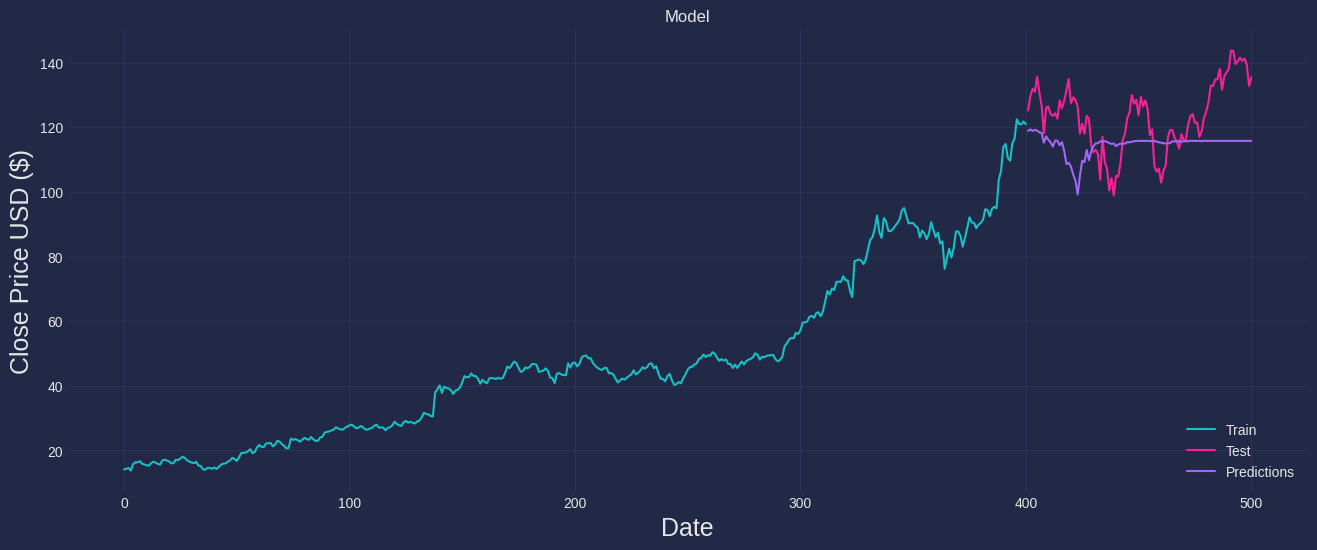

In [91]:
# Plot the predicted stock prices against actual prices
dataset = nvidia_data.filter(['Close'])
train = dataset[:training_data_len]
test = dataset[training_data_len:]
test['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [92]:
test

,Close,Predictions
401,125.199997,118.928841
402,129.610001,119.298471
403,131.880005,118.856341
404,130.979996,119.193141
405,135.580002,118.956081
...,...,...
496,140.520004,115.771061
497,141.250000,115.771061
498,139.339996,115.771061
499,132.759995,115.771061


Text(0, 0.5, 'Actual Values')

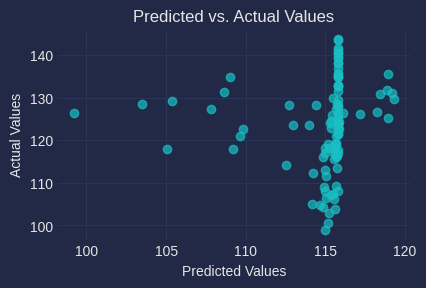

In [93]:
# Evaluate how well the Random Forest model performs.
# If the predictions perfectly match the actual values, the points should align along a straight line with a slope of 1.

#actual_values = y_test
#predicted_values = predictions

y_test = np.array(y_test)  # Add this line
y_test_transformed = scaler.inverse_transform(y_test.reshape(-1, 1))  # Add this line
actual_values = y_test_transformed  # Change this line
predicted_values = predictions  # This line stays the same

plt.figure(figsize=(10, 6))

# Scatter plot of predicted vs. actual values
plt.subplot(2, 2, 1)
plt.scatter(predicted_values, actual_values, alpha=0.7)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

Text(0, 0.5, 'Residuals')

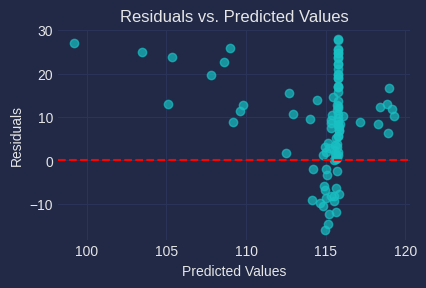

In [94]:
# Evaluate the relationship between observed and predicted values.
# Residuals distributed randomly around y = 0 indicate a well-captured data structure, whereas patterns or trends indicate model inadequacy.

# Calculate residuals
residuals = actual_values - predicted_values
plt.figure(figsize=(10, 6))

# Residuals vs. Predicted Values
plt.subplot(2, 2, 2)
plt.scatter(predicted_values, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Frequency')

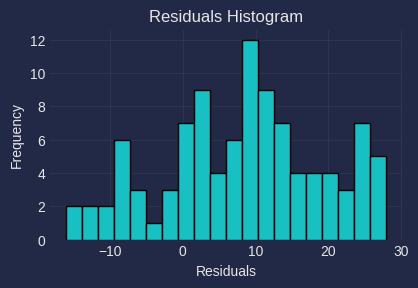

In [95]:
plt.figure(figsize=(10, 6))

# Residuals Histogram
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')